In [4]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

%load_ext autoreload
%autoreload 2

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from src.eda import *
from src.regression import *
from src.visualization import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Data Preparation and Understanding
> ### Make a function call to read and merge to a consolidated dataframe.
> ### Function: Consodidate_data (year, create)
>> ####    Parameter: 1) Year: Year to analyze (as yyyy)
>> ####               2) Create: `True` -- Create a `consolidated.csv` from reading all input files in data directory
>> ####                          `False`-- Read from 'consolidated.csv' 
>> ####.   Returns: dataframe of consolidated attributes to use it in the model

In [5]:
# Returns df_merged with selected columns from each file. Also, save the contents to ./data/consolidated.csv to load to avoid creating data each time.
df_merged = consolidate_data(year=2019, create=False)

In [3]:
# Cleanup data before building regression model
df_merged = data_cleanup(df_merged)

Before dropping nan zipcode records :  (30235, 60)
After dropping nan zipcode records :  (24610, 60)
Before dropping sale price < 20000 records :  (24610, 60)
After dropping sale prices 2000 :  (24447, 60)


Exploring merged data file:
           SalePrice  PropertyType  PrincipalUse  PropertyClass          Area  \
count  2.444300e+04  24443.000000  24443.000000   24443.000000  24443.000000   
mean   8.443423e+05      7.997709      6.003355       7.970585     47.566338   
std    1.290281e+06      4.787250      0.077214       0.367434     27.240433   
min    2.000000e+04      0.000000      2.000000       1.000000      1.000000   
25%    4.500000e+05      3.000000      6.000000       8.000000     25.000000   
50%    6.450000e+05     11.000000      6.000000       8.000000     46.000000   
75%    8.875000e+05     11.000000      6.000000       8.000000     71.000000   
max    2.098540e+07     99.000000      7.000000       9.000000    100.000000   

            SubArea       SqFtLot   WaterS

In [8]:
# Get the pairwise correlation of 'SalePrice' with other factors & a complete correlation matrix
corr = data_correlation(df_merged)
corr



Sale Price Correlation:
 SalePrice               1.000000
PrincipalUse            0.531227
SqFtTotLiving           0.244246
NbrLivingUnits          0.242458
LakeWashington          0.174487
SqFt2ndFloor            0.174432
BathFullCount           0.158157
SqFt1stFloor            0.156543
TidelandShoreland       0.143046
SqFtOpenPorch           0.130864
Stories                 0.127649
Bedrooms                0.125286
SqFtGarageAttached      0.118534
SqFtFinBasement         0.087180
BathHalfCount           0.082225
WfntLocation            0.080238
SeattleSkyline          0.077896
SqFtTotBasement         0.075504
Bath3qtrCount           0.069956
FpMultiStory            0.064331
LakeSammamish           0.063626
SqFtDeck                0.056843
SewerSystem             0.055000
SubArea                 0.054052
WfntBank                0.053398
OtherView               0.042663
YrRenovated             0.040814
HeatSystem              0.034444
WaterSystem             0.028021
SqFtUpperFloor  

,SalePrice,PropertyType,PrincipalUse,PropertyClass,Area,SubArea,SqFtLot,WaterSystem,SewerSystem,Access,...,SqFtDeck,HeatSystem,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,YrRenovated,PcntComplete
SalePrice,1.000000,-0.057640,0.531227,-0.672217,-0.059206,0.054052,-0.029019,0.028021,0.055000,-0.009393,...,0.056843,0.034444,0.125286,0.082225,0.069956,0.158157,0.005442,0.064331,0.040814,0.014619
PropertyType,-0.057640,1.000000,-0.043920,0.047550,-0.000052,0.015698,-0.074323,0.045417,0.027674,-0.003567,...,0.015136,0.041005,0.024467,0.021131,0.004174,0.024848,0.019411,0.000457,0.000409,-0.008148
PrincipalUse,0.531227,-0.043920,1.000000,-0.695925,-0.028855,0.039964,-0.002492,0.008077,0.014524,0.010846,...,-0.021887,-0.017275,0.006524,-0.032312,-0.022017,0.015760,-0.040904,-0.027933,-0.011125,0.023286
PropertyClass,-0.672217,0.047550,-0.695925,1.000000,0.028299,-0.053103,0.004437,-0.008981,-0.023609,-0.015612,...,0.036559,0.034369,-0.018623,0.039600,0.036023,-0.028654,0.042817,0.037373,0.019131,-0.106344
Area,-0.059206,-0.000052,-0.028855,0.028299,1.000000,0.135357,0.085367,-0.174232,-0.229820,-0.055935,...,0.014448,-0.002884,0.025133,0.074808,-0.013383,0.062960,0.095755,-0.024009,-0.048788,0.002817
SubArea,0.054052,0.015698,0.039964,-0.053103,0.135357,1.000000,-0.024139,0.043125,0.022622,0.042295,...,-0.005391,-0.008509,0.033682,0.037094,0.013672,0.014556,-0.008647,0.041290,-0.016472,0.000703
SqFtLot,-0.029019,-0.074323,-0.002492,0.004437,0.085367,-0.024139,1.000000,-0.499948,-0.265539,0.004701,...,-0.027093,-0.232541,-0.178529,-0.041346,-0.040754,-0.109592,0.003584,-0.031735,-0.011238,-0.003925
WaterSystem,0.028021,0.045417,0.008077,-0.008981,-0.174232,0.043125,-0.499948,1.000000,0.479992,0.210506,...,-0.066503,0.127376,0.121674,0.025577,0.013742,0.059425,0.020043,0.029667,-0.008854,0.006703
SewerSystem,0.055000,0.027674,0.014524,-0.023609,-0.229820,0.022622,-0.265539,0.479992,1.000000,0.191740,...,-0.116757,0.088797,0.080301,0.018241,0.009923,0.054346,-0.011623,-0.007239,-0.008039,0.019420
Access,-0.009393,-0.003567,0.010846,-0.015612,-0.055935,0.042295,0.004701,0.210506,0.191740,1.000000,...,-0.108076,-0.037642,0.008549,-0.036607,-0.060517,-0.024721,-0.006027,-0.023302,-0.002230,0.011394


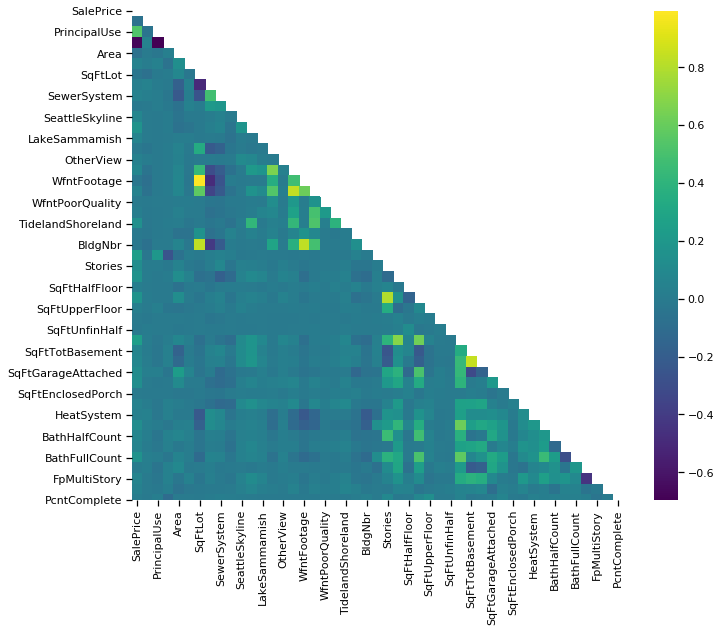

In [83]:
# Create heatmap for all factors to get a general idea
create_heatmap(df_merged, 'merged_heatmap' )

In [10]:
# also, create a pairplot .. though not very useful but will help to spot some visual clues
# create_pairplot(df_merged, 'merged_pairplot')

# create regression models

In [53]:
x_sqft = ['SalePrice', 'SqFtLot','SqFt1stFloor','SqFtHalfFloor','SqFt2ndFloor', 'SqFtUpperFloor',\
          'SqFtUnfinFull','SqFtUnfinHalf', 'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement', 'SqFtGarageAttached',\
          'SqFtOpenPorch','SqFtEnclosedPorch', 'SqFtDeck']
x_amenity = ['SalePrice', 'NbrLivingUnits', 'Stories','HeatSystem', 'Bedrooms' , 'DaylightBasement',\
            'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'FpSingleStory', 'FpMultiStory', 'YrRenovated', 'PcntComplete' ]

x_reg = ['SalePrice', 'PrincipalUse','SqFtTotLiving', 'NbrLivingUnits', 'LakeWashington', 'SqFt1stFloor', \
 'TidelandShoreland','BathFullCount','SqFtOpenPorch','SqFtEnclosedPorch','Stories','Bedrooms','Area', 'PropertyClass', 'SqFtLot', 'WfntLocation', \
         'SqFtTotBasement', 'SqFtFinBasement']

# x_cat = ['PropType','WfntAccessRights','WfntProximityInfluence','PowerLines','OtherNuisances']
x_cat = ['PowerLines', 'DaylightBasement']

#For nuisance analysis
x_nuisance = ['SalePrice', 'TrafficNoise',  "PowerLines", 'OtherNuisances']


df_sqft = df_merged[x_sqft]
df_amenity = df_merged[x_amenity]
df_reg = df_merged[x_reg]
df_cat = df_merged[x_cat]

df_nuisance = df_merged[x_nuisance]
df_porch = df_merged[['SalePrice','SqFtOpenPorch', 'SqFtEnclosedPorch']]

> ### Create regression model for all factors that has SqFt characteistics

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     116.6
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        07:38:51   Log-Likelihood:            -3.7781e+05
No. Observations:               24443   AIC:                         7.557e+05
Df Residuals:                   24428   BIC:                         7.558e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
SqFtLot               -0.0112      0

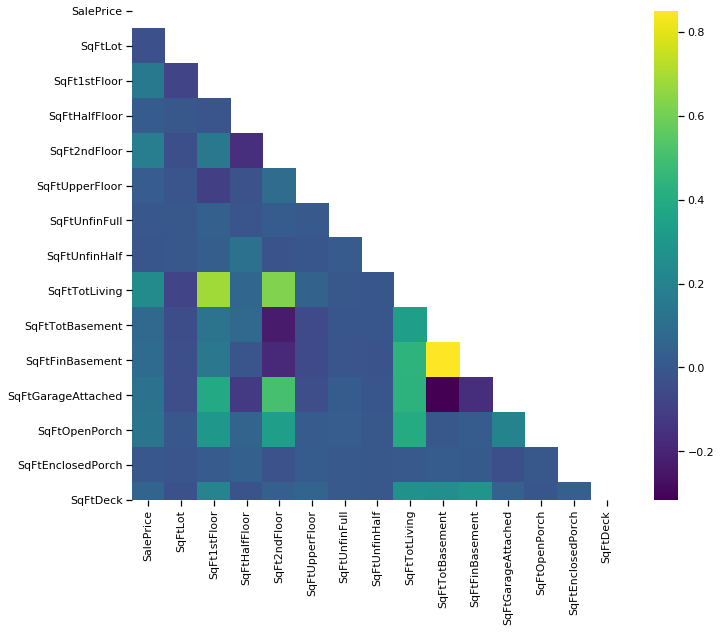

In [84]:
# Create heatmap for all factors that has SqFt characteistics
create_heatmap(df_sqft, 'sqft_heatmap' )

# Create paiplot of all factors that has SqFt characteristics
# create_pairplot(df_merged, 'sqft_pairplot')

# Run ols regression model
run_ols_regression(df_sqft, 'SalePrice')

> ### Create regression model with high degree of correlation 

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     1838.
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        05:56:13   Log-Likelihood:            -3.6854e+05
No. Observations:               24443   AIC:                         7.371e+05
Df Residuals:                   24425   BIC:                         7.373e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
PrincipalUse       2.093e+06   9.87e+0

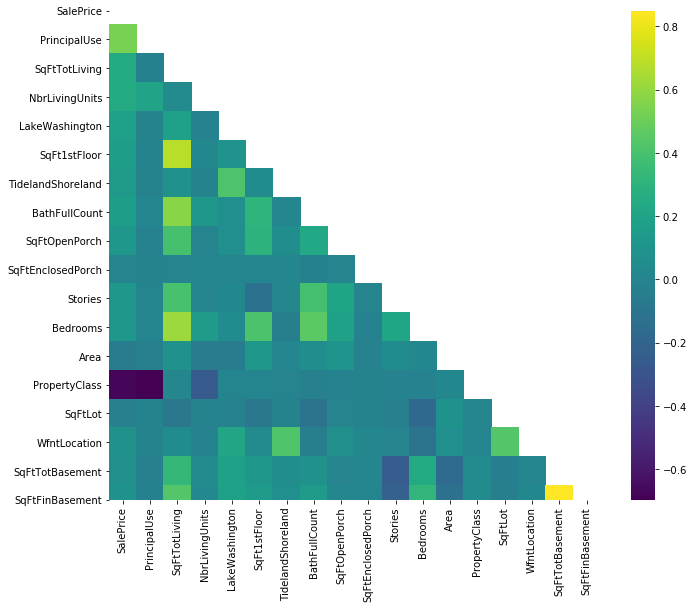

In [13]:
# Create heatmap for all factors that has SqFt characteistics
create_heatmap(df_reg, 'sqft_heatmap' )

# Create paiplot of all factors that has SqFt characteristics
# create_pairplot(df_reg, 'sqft_pairplot')

# Run ols regression model
run_ols_regression(df_reg, 'SalePrice')

> ### Looks, good. We can add a few categorical predictors and check if we hav better R-squared

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     1565.
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        07:39:08   Log-Likelihood:            -3.6853e+05
No. Observations:               24443   AIC:                         7.371e+05
Df Residuals:                   24422   BIC:                         7.373e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
PrincipalUse       2.093e+06   9.87e+0

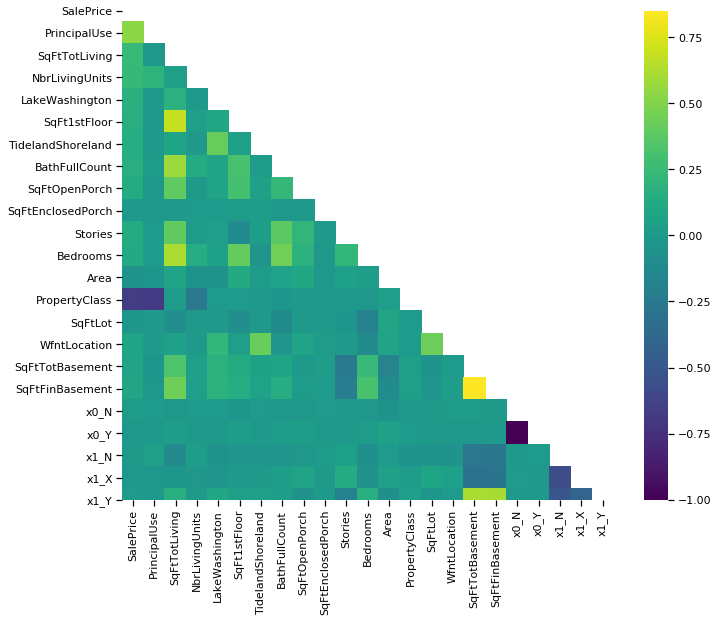

In [85]:
# Let's add a categorical
#ohe = OneHotEncoder(drop='first', sparse=False)
ohe = OneHotEncoder(sparse=False)
df_cat_trans = ohe.fit_transform(df_cat)
df_cat_t = pd.DataFrame(df_cat_trans, index=df_cat.index, columns=ohe.get_feature_names())
df_cat_new = df_reg.join(df_cat_t )

# Create heatmap for all factors that has SqFt characteistics
create_heatmap(df_cat_new, 'reg_cat_heatmap' )

# Create paiplot of all factors that has SqFt characteristics
# create_pairplot(df_cat_new, 'reg_cat_pairplot')

# Run ols regression model
run_ols_regression(df_cat_new, 'SalePrice')

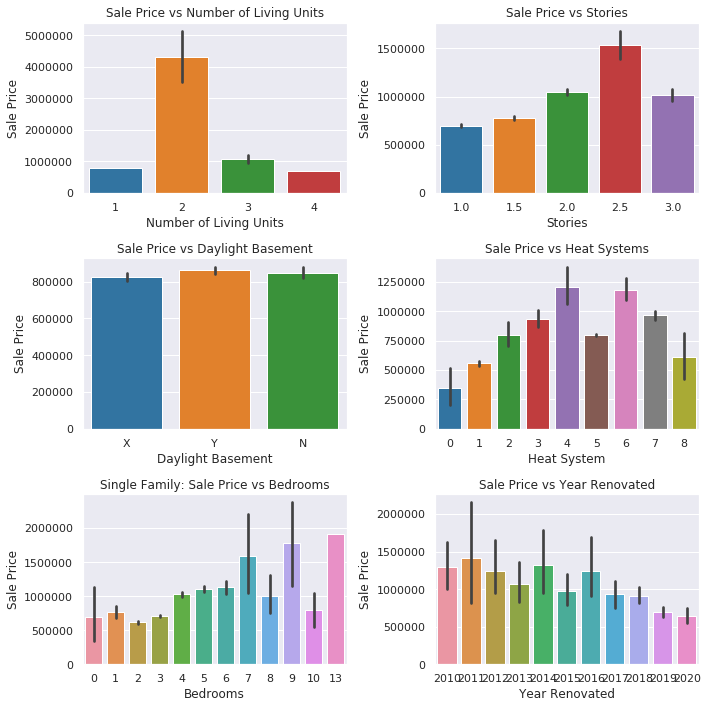

In [86]:
# Let's go create charts for the amenity features

f = plt.figure(figsize=(10, 10))
gs = f.add_gridspec(3,2)

# 1) Sale Price vs Number of Living Units
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 0])
    sns.barplot(x=df_amenity['NbrLivingUnits'], y=df_amenity['SalePrice']).set( \
                title='Sale Price vs Number of Living Units', \
                xlabel='Number of Living Units', ylabel='Sale Price');

# 2) Chart for Number of Stories
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[0, 1])
    sns.barplot(x=df_amenity['Stories'], y=df_amenity['SalePrice']).set( \
            title='Sale Price vs Stories', 
            xlabel='Stories', ylabel='Sale Price');
    
# 3) Chart for Daylight Basement
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 0])
    sns.barplot(x=df_amenity['DaylightBasement'], y=df_amenity['SalePrice']).set( \
            title='Sale Price vs Daylight Basement', \
            xlabel='Daylight Basement', ylabel='Sale Price');
    
# 4) Chart for Heat Systems
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[1, 1])    
    sns.barplot(x=df_amenity['HeatSystem'], y=df_amenity['SalePrice']).set( \
            title='Sale Price vs Heat Systems', \
            xlabel='Heat System', ylabel='Sale Price');
    
# 5) Chart for Number of Bedrooms
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[2,0])
    sns.barplot(x=df_amenity['Bedrooms'], y=df_amenity['SalePrice']).set( \
            title='Single Family: Sale Price vs Bedrooms', \
            xlabel='Bedrooms', ylabel='Sale Price');

# 6) Chart for Bedrooms
with sns.axes_style("darkgrid"):
    ax = f.add_subplot(gs[2, 1]) 
    df_t = df_amenity[df_amenity['YrRenovated'] >= 2010]
    sns.barplot(x=df_t['YrRenovated'], y=df_t['SalePrice']).set( \
            title='Sale Price vs Year Renovated', \
            xlabel='Year Renovated', ylabel='Sale Price');
f.tight_layout()
f.savefig("./visualization/amenities.png")

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


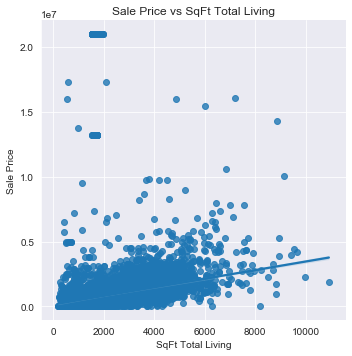

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


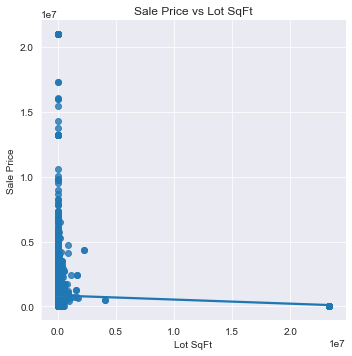

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


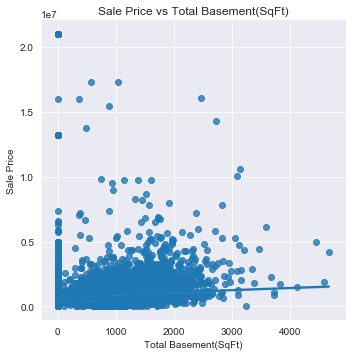

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


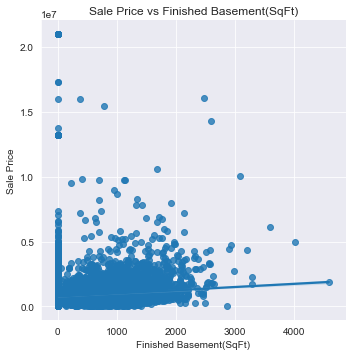

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


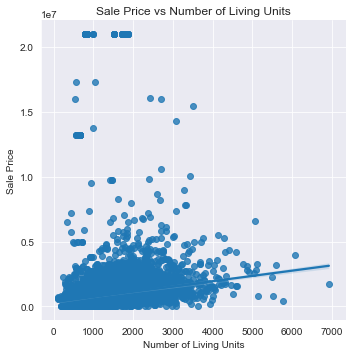

In [22]:
# Create lmplots to create regression charts

# 1) Sale Price vs Number of Living Units
with sns.axes_style("darkgrid"):
    ax = f.add_subplot()
    sns.lmplot(x="SqFtTotLiving",y="SalePrice",data=df_sqft).set( \
                 title='Sale Price vs SqFt Total Living', \
                 xlabel='SqFt Total Living', ylabel='Sale Price');
    plt.show()
    f.savefig("./visualization/reg-SqFtTotLiving.png")
    
# 2) Sale Price vs SqFt Lot size
with sns.axes_style("darkgrid"):
    ax = f.add_subplot()
    sns.lmplot(x="SqFtLot",y="SalePrice",data=df_sqft).set( \
                title='Sale Price vs Lot SqFt', \
                xlabel='Lot SqFt', ylabel='Sale Price');
    plt.show()
    f.savefig("./visualization/reg-SqFtLot.png")
    
# 3) Chart SQFt Total Basement
with sns.axes_style("darkgrid"):
    ax = f.add_subplot()
    sns.lmplot(x="SqFtTotBasement",y="SalePrice",data=df_sqft).set( \
                title='Sale Price vs Total Basement(SqFt)', \
                xlabel='Total Basement(SqFt)', ylabel='Sale Price');
    plt.show()
    f.savefig("./visualization/reg-SqFtBasement.png")

# # 4) Chart SQFt Finished Basement
with sns.axes_style("darkgrid"):
    ax = f.add_subplot()
    sns.lmplot(x="SqFtFinBasement",y="SalePrice",data=df_sqft).set( \
                title='Sale Price vs Finished Basement(SqFt)', \
                xlabel='Finished Basement(SqFt)', ylabel='Sale Price');                                                
    plt.show()
    f.savefig("./visualization/reg_SqFtFinBasement.png")                                                    

# # 5) Sale Price vs Number of Living Units
with sns.axes_style("darkgrid"):
    ax = f.add_subplot()
    sns.lmplot(x="SqFt1stFloor",y="SalePrice",data=df_sqft).set( \
                title='Sale Price vs Number of Living Units', \
                xlabel='Number of Living Units', ylabel='Sale Price');  
    plt.show()
    f.savefig("./visualization/reg_SqFt1stFroor.png")  

# 2. Having a porch increases home sale price

In [23]:
df_porch = df_reg[['SalePrice','SqFtOpenPorch', 'SqFtEnclosedPorch']]

In [24]:
df_porch['SqFtEnclosedPorch'].describe() 

count    24443.000000
mean         6.067954
std         38.587137
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1840.000000
Name: SqFtEnclosedPorch, dtype: float64

In [25]:
df_porch['SqFtOpenPorch'].describe()

count    24443.00000
mean        67.08440
std        119.54036
min          0.00000
25%          0.00000
50%          0.00000
75%         90.00000
max       2870.00000
Name: SqFtOpenPorch, dtype: float64

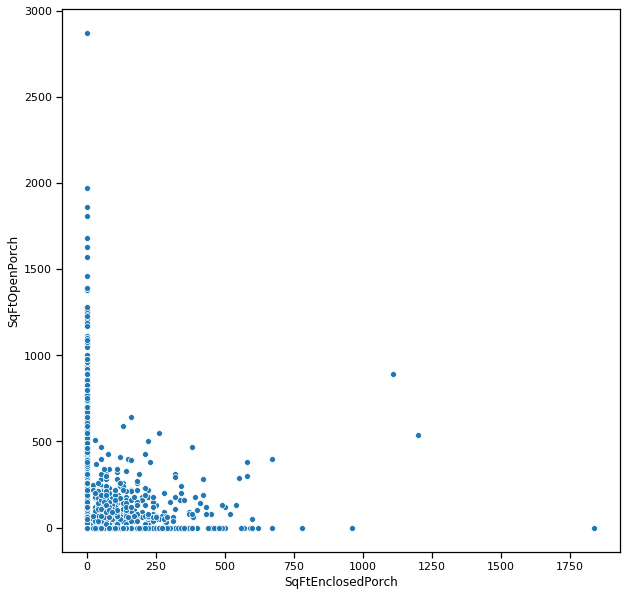

In [87]:
create_scatterplot_df(df_porch, "porch")

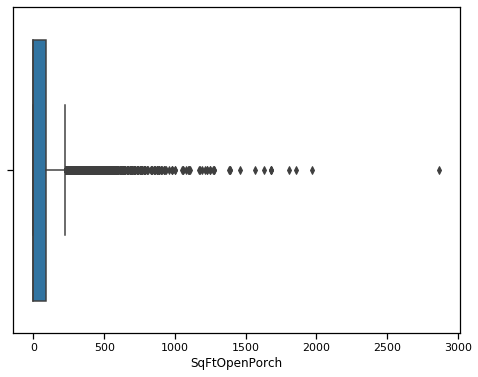

In [27]:
create_boxplot(df_porch, 'SqFtOpenPorch')

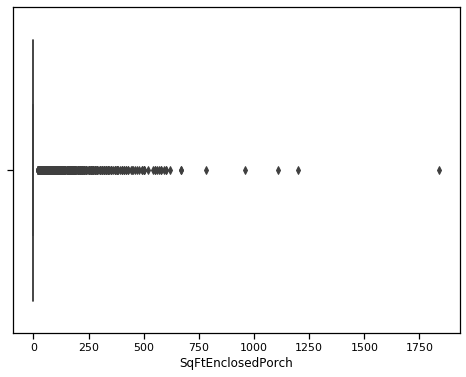

In [28]:
create_boxplot(df_porch, 'SqFtEnclosedPorch')

In [29]:
df_porch['TotalPorch'] = df_porch['SqFtEnclosedPorch'] + df_porch['SqFtOpenPorch']

/Users/lalithap/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


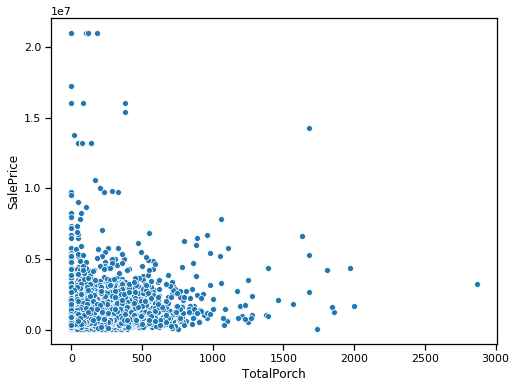

In [30]:
create_scatterplot(df_porch, 'TotalPorch', 'SalePrice', 'scatter_SalePrice_TotalPorcjh')

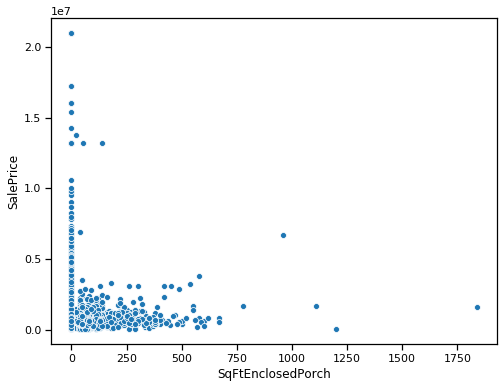

In [31]:
create_scatterplot(df_porch, "SqFtEnclosedPorch", "SalePrice", 'saleprice_sqftEnclosedPorch' )

In [32]:
df_porch.sort_values(by=['SqFtOpenPorch'], ascending = False)
df_porch.sort_values(by=['SqFtEnclosedPorch'], ascending = False)


,SalePrice,SqFtOpenPorch,SqFtEnclosedPorch,TotalPorch
19863,1600000,0,1840,1840
9126,27225,540,1200,1740
29080,1685000,890,1110,2000
11264,6670000,0,960,960
16497,1700000,0,780,780
...,...,...,...,...
10267,445000,90,0,90
10265,455774,0,0,0
10264,900000,70,0,70
10263,1025000,560,0,560


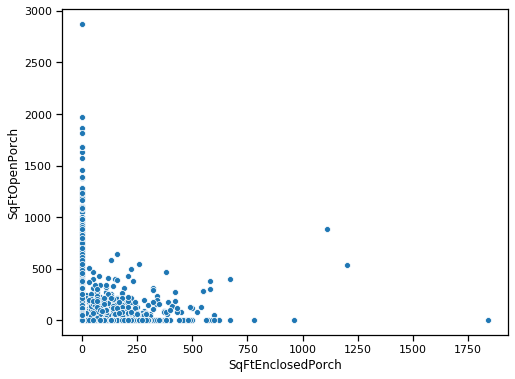

In [67]:
create_scatterplot(df_porch, "SqFtEnclosedPorch", "SqFtOpenPorch", 'SqFtEnc_SqFtOpen' )

/Users/lalithap/Desktop/Flatiron/Group Project/phase2/phase_2_project_chicago-sf-seattle-ds-082420/src/visualization.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colors = ['#f47a60', '#ced7d8', '#7fe7dc', '#316879']


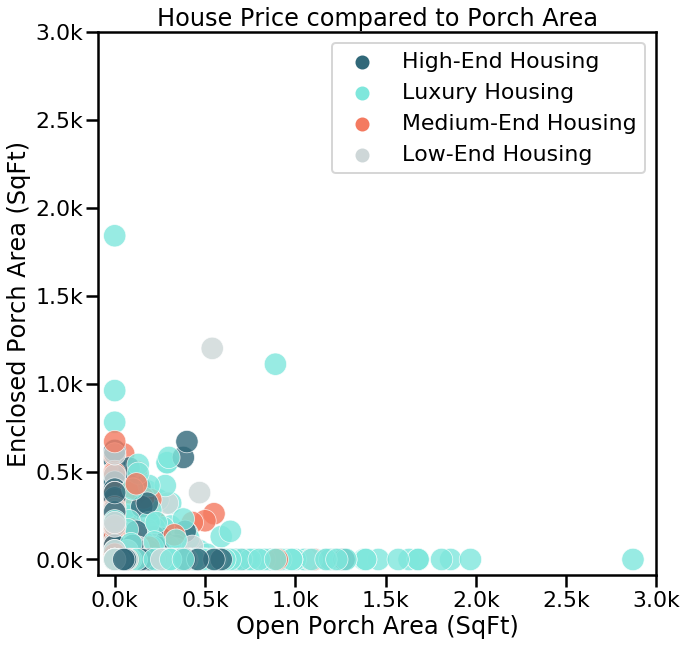

In [90]:
porch_vs_house_price(df_porch)

# 3) Having a beachfront or lakefront increases home sale price

0    23904
9      149
8      128
6      118
3       96
7       37
5        7
1        4
Name: WfntLocation, dtype: int64

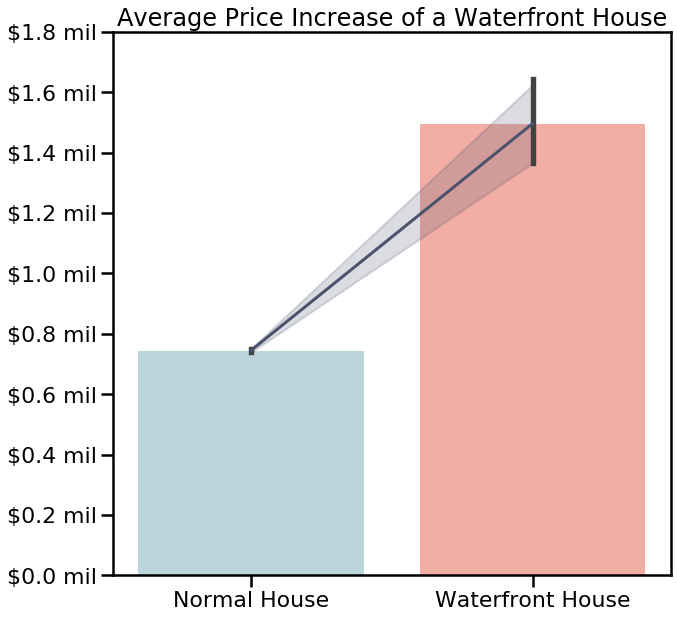

<Figure size 432x288 with 0 Axes>

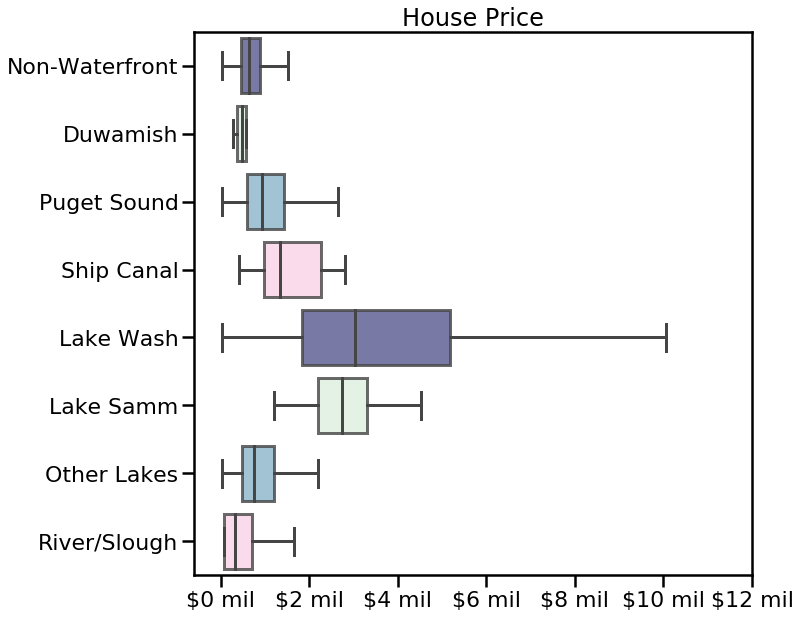

In [89]:
water_front_sales(df_merged)

## 3) Nuisance factors reduce the sale price of houses

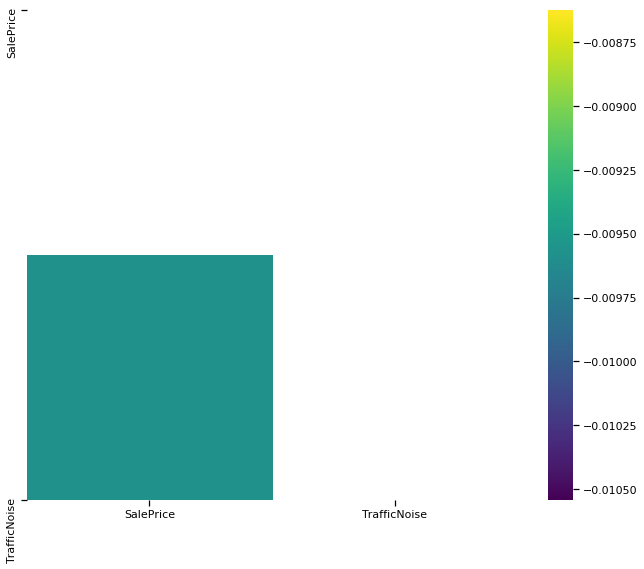

In [61]:
# Create heatmap for all factors that has SqFt characteistics
#create_heatmap(df_nuisance, 'nuisance_heatmap' )

# Create paiplot of all factors that has SqFt characteristics
#create_pairplot(df_nuisance, 'nuisance_pairplot')